# Usefull Time series related blogs 2

## Time Series Forecasting with Conformal Prediction Intervals: Scikit-Learn is All you Need

Accurate Uncertainty Quantification with MAPIE and TSPIRAL

Enriching our forecasts with prediction intervals is the key. Practically speaking a prediction interval is represented by a couple of numbers. These values are respectively a lower and an upper bound where future observations are likely to occur. The likelihood that the future values fall in the given bound is expressed by a floating number (alpha) between 0 and 1. Where an alpha near one means that we are more confident that this happen.

It’s straightforward to understand the added value of attaching a prediction interval to our forecasts. Providing an uncertainty estimation is an old need that can be solved in various ways. All methods are awesome if properly adopted, but some are better. Let’s try to elaborate.

Everyone knows **bootstrapping** as a resampling technique. **It’s common to see bootstrapping applied to forecasting residuals to obtain an uncertainty measure for future forecasts**. Despite residual bootstrapping may be a good starting point when approaching for the first time uncertainty quantification, it may lead to poor performance since it only takes care of data uncertainty. Another source of uncertainty exists. We are referring to the modeling uncertainty. Modeling uncertainty takes care of possible lack of knowledge encountered in the training phases, which may influence forecasts. **A good forecasting uncertainty measure should encompass both data and modeling uncertainties**.

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from mapie.time_series_regression import MapieRegressor

from tsprial.model_selection import TemporalSplit
from tsprial.forecasting import ForecastingCascade, ForecastingChain

### Setting up Forecasting

The first step for producing prediction intervals consists in choosing the forecasting model to use. That seems not reasonable but it’s one of the main benefits of conformal prediction since it’s a model-agostic technique (i.e. it can be used in any context with any predictive algorithms).

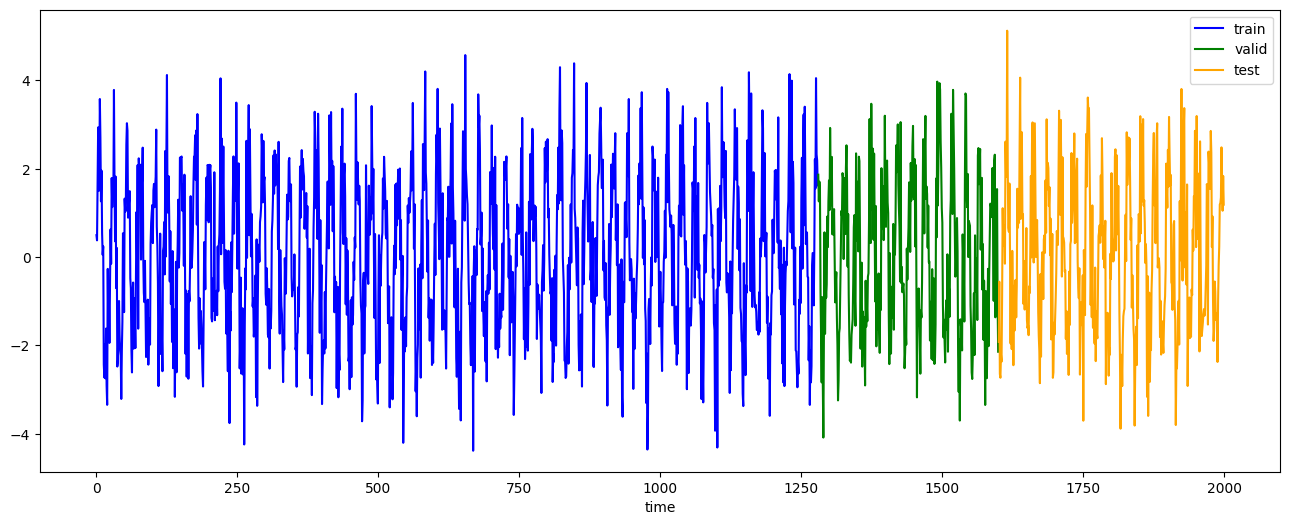

In [5]:
### SYNTETIC DATA GENERATION ###

timesteps = 2_000
e = np.random.normal(0,1, (timesteps,))

y = 2*np.sin(np.arange(timesteps)*(2*np.pi/24))+e

X_train_val, X_test, y_train_val, y_test = train_test_split(
    np.arange(timesteps), y, test_size=0.2, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False
)

plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, c='blue', label='train')
plt.plot(X_val, y_val, c='green', label='valid')
plt.plot(X_test, y_test, c='orange', label='test')
plt.xlabel('time'); plt.legend(); plt.show()

Let’s imagine having produced the forecasting depicted below using a simulated sinusoidal series. How is it possible to add reliable prediction intervals to our predictions?

### Generating Conformal Prediction Intervals

To solve the problem we can use conformal prediction. Conformal prediction intervals are built by studying the distributions of the residuals. There isn’t any secret receipt or any sort of magic.

Given the predictions and the true values on a validation set, we have to:

- compute the absolute residuals (conformity_scores).
- add the conformity scores to the test predictions. This generates distributions for each point-wise test forecast (estimated_distributions).
- compute upper and lower quantiles for each point-wise forecast distribution to obtain prediction intervals.

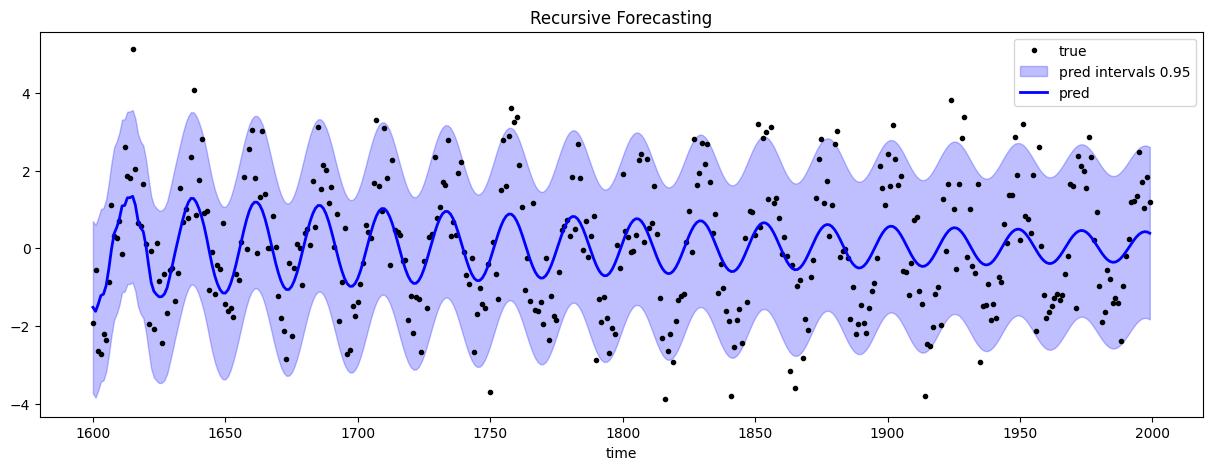

In [6]:
### CONFORMAL PREDICTION WITH RECURSIVE FORECASTING ###

forecaster = ForecastingCascade(
    Ridge(),
    lags=range(1,24+1),
    use_exog=False,
)

forecaster.fit(None, y_train)
y_pred_val_rec = forecaster.predict(X_val)

model = MapieRegressor(
    forecaster, cv="prefit"
).fit(X_val, y_val)

forecaster.fit(None, y_train_val)
model.single_estimator_ = forecaster

y_pred_test_rec = model.predict(X_test, alpha=0.05)


plt.figure(figsize=(15,5))
plt.plot(X_test, y_test, '.k', label='true')
plt.fill_between(X_test, y_pred_test_rec[1][:, 0, 0], y_pred_test_rec[1][:, 1, 0], 
                 alpha=0.25, color='blue', label='pred intervals 0.95')
plt.plot(X_test, y_pred_test_rec[0], 'blue', linewidth=2, label='pred')
plt.title('Recursive Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

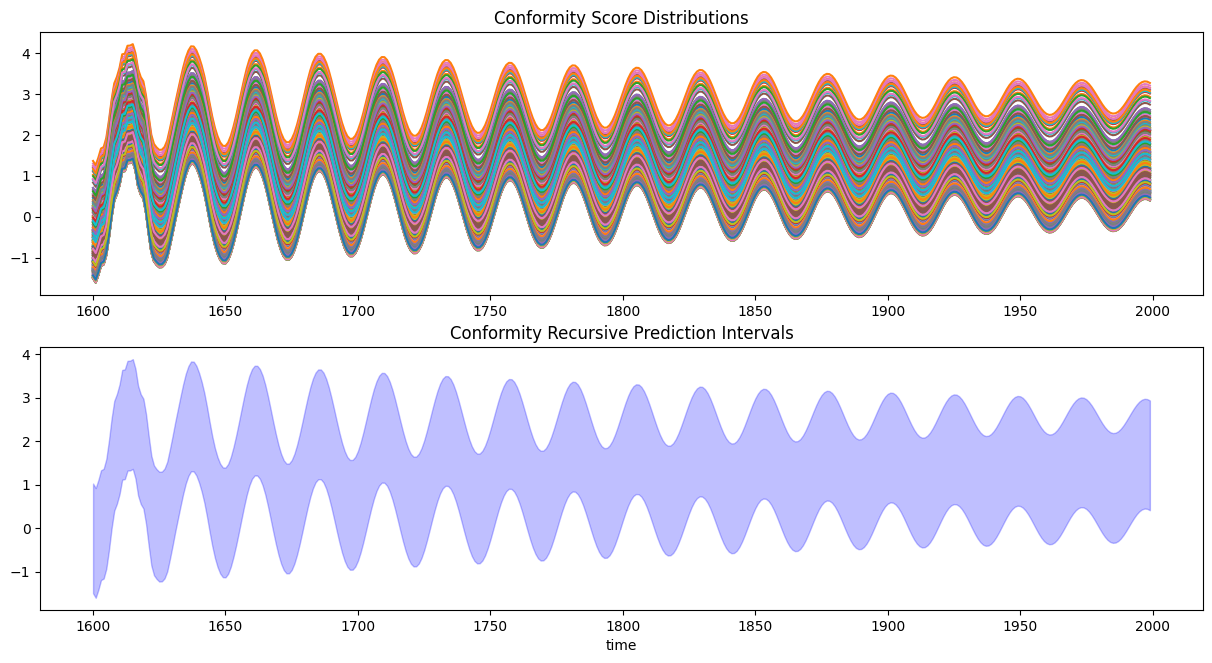

In [7]:
### HOW CONFORMITY SCORES ARE GENERATED WITH RECURSIVE FORECASTING ###

alpha = 0.95
conformity_scores = np.abs(np.subtract(y_val, y_pred_val_rec))
estimated_distributions = np.add(y_pred_test_rec[0][:, None], conformity_scores)

lower_q, upper_q = np.quantile(
    estimated_distributions, 
    [(1-alpha)/2, 1-(1-alpha)/2], axis=1
)


plt.figure(figsize=(15,7.5))
plt.subplot(2,1,1)
plt.plot(X_test, estimated_distributions)
plt.title('Conformity Score Distributions')
plt.subplot(2,1,2)
plt.fill_between(X_test, lower_q, upper_q, alpha=0.25, color='blue')
plt.title('Conformity Recursive Prediction Intervals')
plt.xlabel('time')
plt.show()

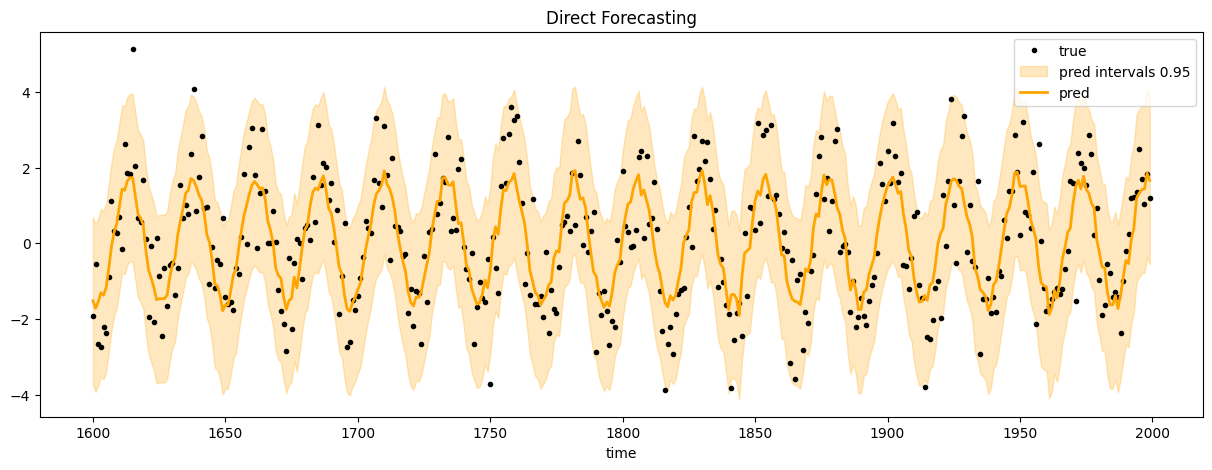

In [8]:
### CONFORMAL PREDICTION WITH DIRECT FORECASTING ###

forecaster = ForecastingChain(
    Ridge(),
    n_estimators=len(y_test),
    lags=range(1,24+1),
    use_exog=False
)

forecaster.fit(None, y_train)
y_pred_val_dir = forecaster.predict(X_val)

model = MapieRegressor(
    forecaster, cv="prefit"
).fit(X_val, y_val)

forecaster.fit(None, y_train_val)
model.single_estimator_ = forecaster

y_pred_test_dir = model.predict(X_test, alpha=0.05)


plt.figure(figsize=(15,5))
plt.plot(X_test, y_test, '.k', label='true')
plt.fill_between(X_test, y_pred_test_dir[1][:, 0, 0], y_pred_test_dir[1][:, 1, 0], 
                 alpha=0.25, color='orange', label='pred intervals 0.95')
plt.plot(X_test, y_pred_test_dir[0], 'orange', linewidth=2, label='pred')
plt.title('Direct Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

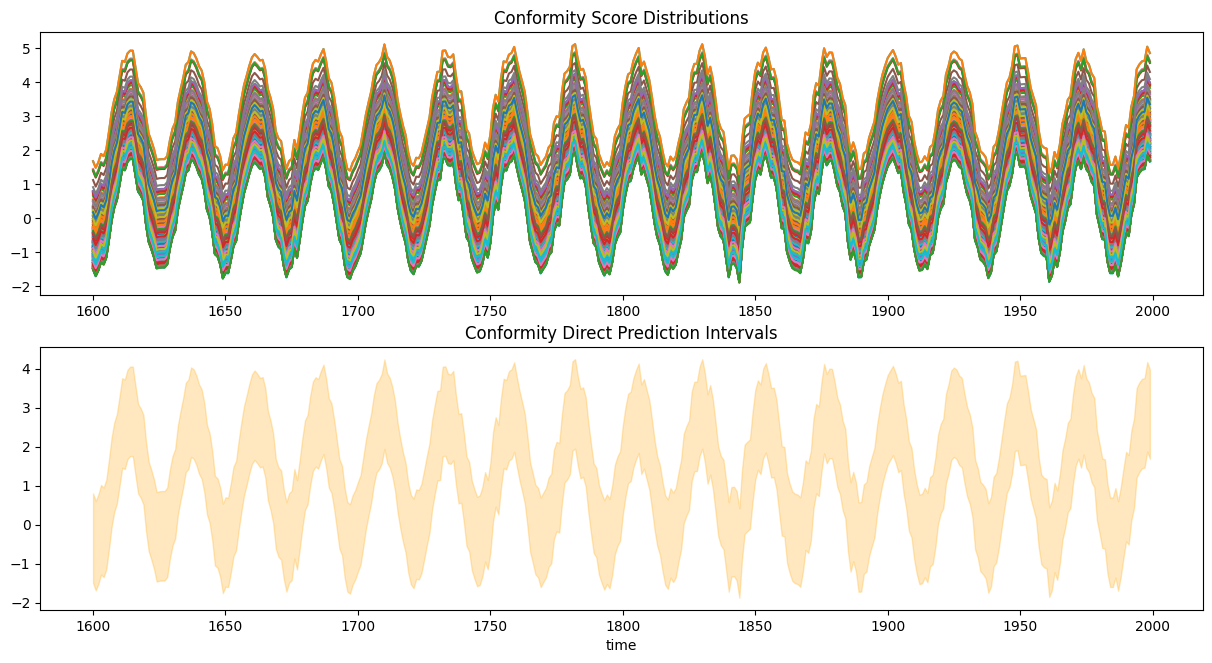

In [9]:
### HOW CONFORMITY SCORES ARE GENERATED WITH DIRECT FORECASTING ###

conformity_scores = np.abs(np.subtract(y_val, y_pred_val_dir))
estimated_distributions = np.add(y_pred_test_dir[0][:, None], conformity_scores)

lower_q, upper_q = np.quantile(
    estimated_distributions, 
    [(1-alpha)/2, 1-(1-alpha)/2], axis=1
)


plt.figure(figsize=(15,7.5))
plt.subplot(2,1,1)
plt.plot(X_test, estimated_distributions)
plt.title('Conformity Score Distributions')
plt.subplot(2,1,2)
plt.fill_between(X_test, lower_q, upper_q, alpha=0.25, color='orange')
plt.title('Conformity Direct Prediction Intervals')
plt.xlabel('time')
plt.show()

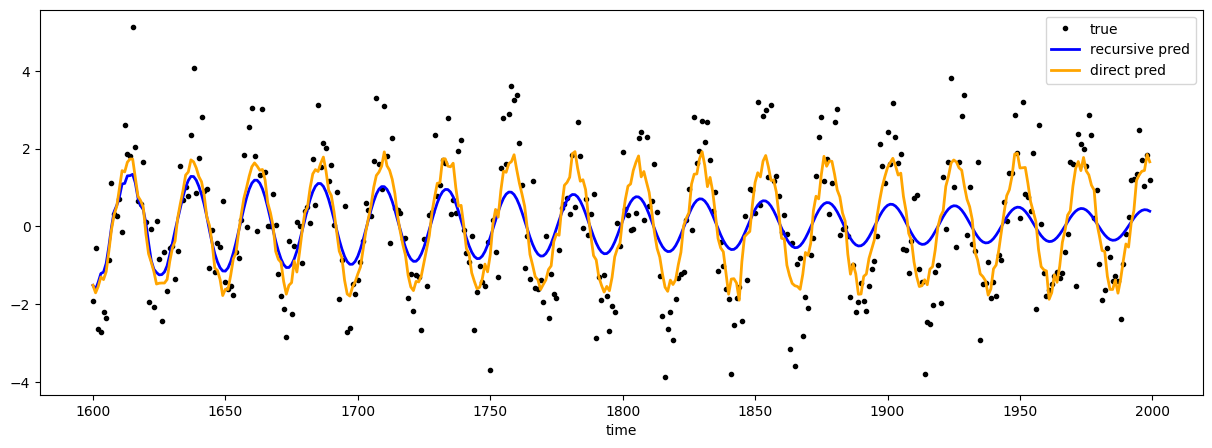

In [10]:
### COMPARING FORECASTING TECHNIQUES ###

plt.figure(figsize=(15,5))
plt.plot(X_test, y_test, '.k', label='true')
plt.plot(X_test, y_pred_test_rec[0], 'blue', linewidth=2, label='recursive pred')
plt.plot(X_test, y_pred_test_dir[0], 'orange', linewidth=2, label='direct pred')
plt.xlabel('time'); plt.legend()
plt.show()

/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/mapie/utils.py:418: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


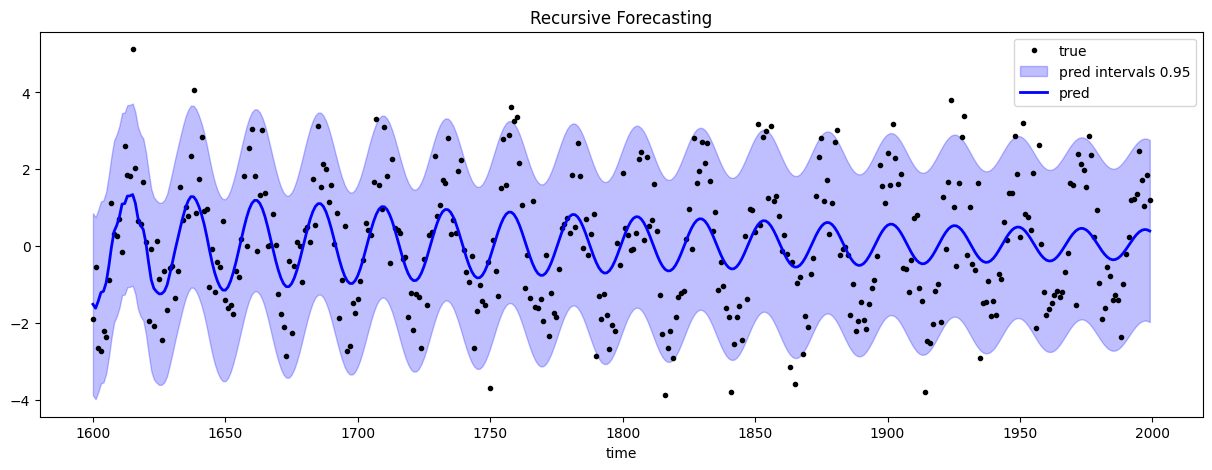

In [11]:
### CONFORMAL PREDICTION WITH RECURSIVE FORECASTING AND CV ###

forecaster = ForecastingCascade(
    Ridge(),
    lags=range(1,24+1),
    use_exog=False,
)

model = MapieRegressor(
    forecaster, 
    cv=TemporalSplit(20, test_size=len(y_test)),
    method='base', agg_function=None, n_jobs=-1
).fit(X_train_val, y_train_val)

y_pred_test_rec = model.predict(X_test, alpha=0.05, ensemble=False)
# warning rises only because TemporalSplit generate not complete data partitions
# don't worry. it's enough to generate conformity scores. NaNs are automatically removed by MAPIE


plt.figure(figsize=(15,5))
plt.plot(X_test, y_test, '.k', label='true')
plt.fill_between(X_test, y_pred_test_rec[1][:, 0, 0], y_pred_test_rec[1][:, 1, 0], 
                 alpha=0.25, color='blue', label='pred intervals 0.95')
plt.plot(X_test, y_pred_test_rec[0], 'blue', linewidth=2, label='pred')
plt.title('Recursive Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/mapie/utils.py:418: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/home/bruno/MachineLearning_Training/TimeSeries_Learning/time_series_analysis/lib/python3.8/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


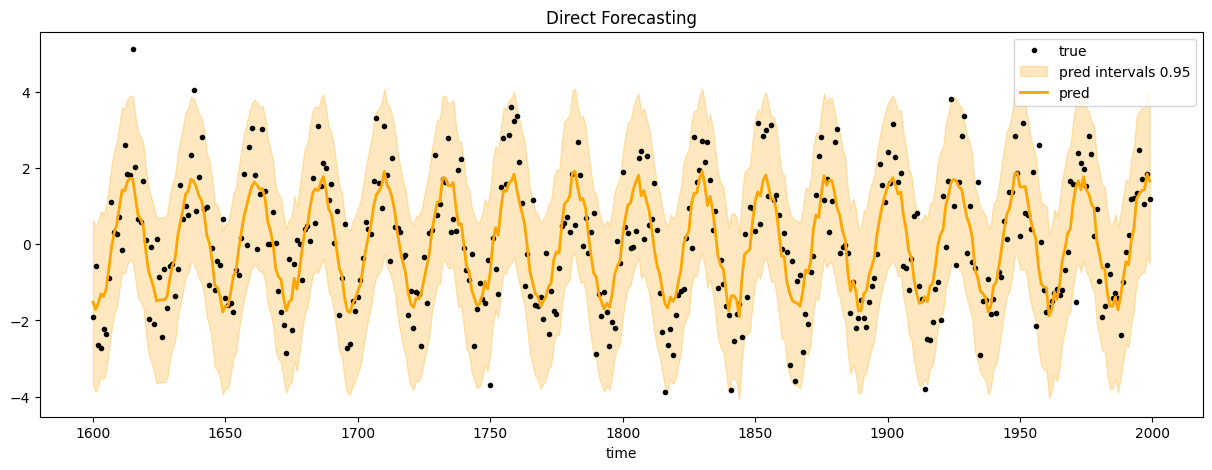

In [12]:
### CONFORMAL PREDICTION WITH DIRECT FORECASTING AND CV ###

forecaster = ForecastingChain(
    Ridge(),
    n_estimators=len(y_test),
    lags=range(1,24+1),
    use_exog=False
)

model = MapieRegressor(
    forecaster, 
    cv=TemporalSplit(20, test_size=len(y_test)),
    method='base', agg_function=None, n_jobs=-1
).fit(X_train_val, y_train_val)

y_pred_test_dir = model.predict(X_test, alpha=0.05, ensemble=False)
# warning rises only because TemporalSplit generate not complete data partitions
# don't worry. it's enough to generate conformity scores. NaNs are automatically removed by MAPIE


plt.figure(figsize=(15,5))
plt.plot(X_test, y_test, '.k', label='true')
plt.fill_between(X_test, y_pred_test_dir[1][:, 0, 0], y_pred_test_dir[1][:, 1, 0], 
                 alpha=0.25, color='orange', label='pred intervals 0.95')
plt.plot(X_test, y_pred_test_dir[0], 'orange', linewidth=2, label='pred')
plt.title('Direct Forecasting'); plt.xlabel('time'); plt.legend()
plt.show()

## Combine LSTM and VAR for Multivariate Time Series Forecasting

In a classical time series forecasting task, the first standard decision when modeling involves the adoption of statistical methods or other pure machine learning models, including tree-based algorithms or deep learning techniques. The choice is strongly related to the problem we are carrying out but in general: statistical techniques are adequate when we face an autoregressive problem when the future is related only to the past; while machine learning models are suitable for more complex situations when it’s also possible to combine variegated data sources.

In this post, I try to combine the ability of the statistical method to learn from experience with the generalization of deep learning techniques. Our task is a multivariate time series forecasting problem, so we use the multivariate extension of ARIMA, known as VAR, and a simple LSTM structure. We don’t produce an ensemble model; we use the ability of VAR to filter and study history and provide benefit to our neural network in predicting the future.

Our workflow can be summarized as follow:

- Estimate a VAR properly on our training data;
- Extract what VAR has learned and use it to improve the training process of an LSTM model performing a two-step training.

We’ll see that our results aren’t obvious because, following this procedure, we have to fight the problem of Catastrophic Forgetting.

In [14]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasRandomSearch, KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

url='https://raw.githubusercontent.com/cerlymarco/MEDIUM_NoteBook/master/LSTM_VAR/AirQualityUCI.csv'

The data for our experiment contains hourly averaged responses from metal oxide chemical sensors embedded in an Air Quality Multisensor Device, located on the field in a significantly polluted area of an Italian city. Data were recorded for one year and contains ground truth hourly averaged concentrations for CO, Non-Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx), and Nitrogen Dioxide (NO2). Also, external variables are provided like weather conditions. A good amount of NaNs are present, so a linear interpolation is required before proceeding (series with more than 50% of NaNs in train data are excluded).

In [15]:
### READ DATA ###

df = pd.read_csv(url, sep=';', parse_dates={'date':['Date', 'Time']})
df.dropna(axis=1, inplace=True, how='all')
df.dropna(inplace=True)

df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')
date = df['date'].values
df.set_index('date', inplace=True)

df.columns = [col.split('(')[0] for col in df.columns]

print(df.shape)
df.head()

(9357, 13)


,CO,PT08.S1,NMHC,C6H6,PT08.S2,NOx,PT08.S3,NO2,PT08.S4,PT08.S5,T,RH,AH
date,,,,,,,,,,,,,
2004-03-10 18:00:00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
2004-03-10 19:00:00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2004-03-10 20:00:00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
2004-03-10 21:00:00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
2004-03-10 22:00:00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [16]:
### ADJUST AND CLEAN DATA ###

df_external = pd.DataFrame(df.index)

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

CO : 0.17986534145559474
PT08.S1 : 0.0391151009939083
NMHC : 0.9023191193758683
C6H6 : 0.0391151009939083
PT08.S2 : 0.0391151009939083
NOx : 0.17516297958747462
PT08.S3 : 0.0391151009939083
NO2 : 0.1754835951693919
PT08.S4 : 0.0391151009939083
PT08.S5 : 0.0391151009939083
T : 0.0391151009939083
RH : 0.0391151009939083
AH : 0.0391151009939083


In [17]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [18]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek
df_external['hour'] = df_external.date.dt.hour

df_external = cycle_encode(df_external, ['month','day','hour'])
df_external.drop(['month','day','hour'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(9357, 9)


,T,RH,AH,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
date,,,,,,,,,
2004-03-10 18:00:00,13.6,48.9,0.7578,1.0,6.123234e-17,0.866025,-0.5,-0.979084,0.203456
2004-03-10 19:00:00,13.3,47.7,0.7255,1.0,6.123234e-17,0.866025,-0.5,-0.887885,0.460065
2004-03-10 20:00:00,11.9,54.0,0.7502,1.0,6.123234e-17,0.866025,-0.5,-0.730836,0.682553
2004-03-10 21:00:00,11.0,60.0,0.7867,1.0,6.123234e-17,0.866025,-0.5,-0.519584,0.854419
2004-03-10 22:00:00,11.2,59.6,0.7888,1.0,6.123234e-17,0.866025,-0.5,-0.269797,0.962917


In [19]:
### SPLIT TRAIN TEST ###

train, test = train_test_split(df, shuffle=False, train_size=0.8)
train_ext, test_ext = train_test_split(df_external, shuffle=False, train_size=0.8)

print(train.shape, test.shape)
print(train_ext.shape, test_ext.shape)

(7485, 9) (1872, 9)
(7485, 9) (1872, 9)


In [20]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

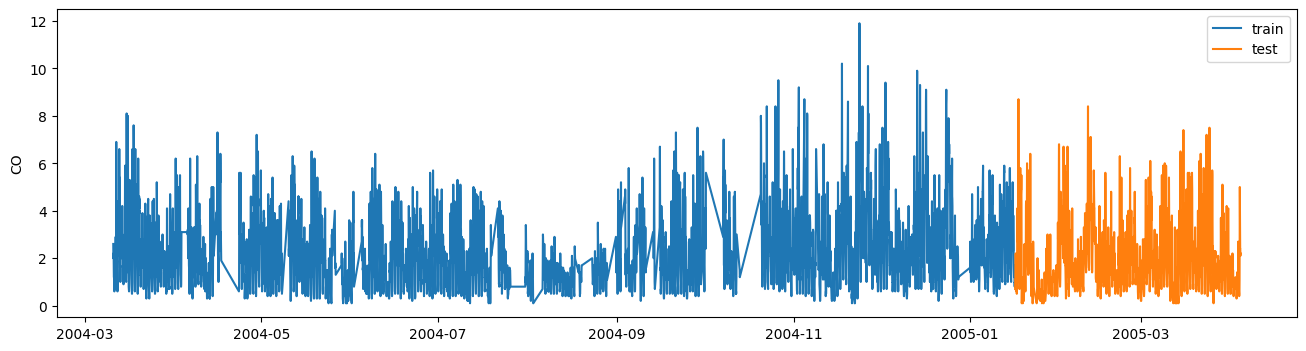

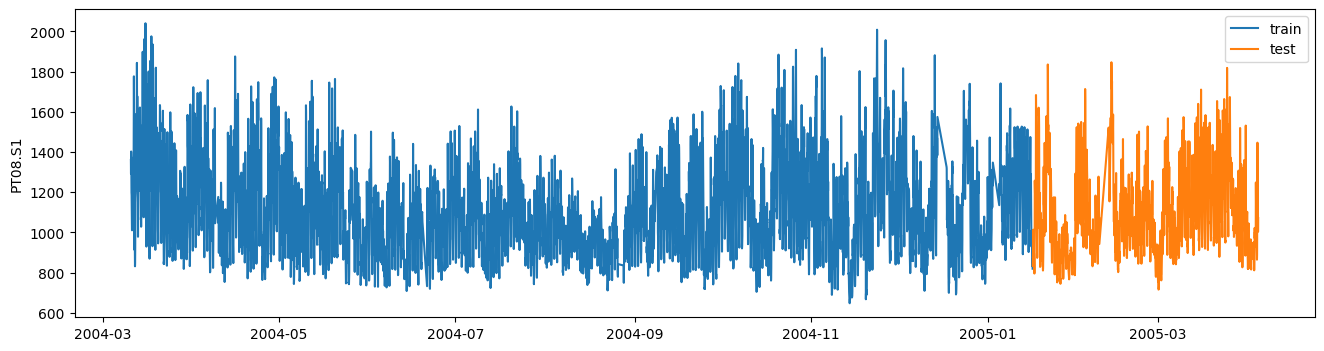

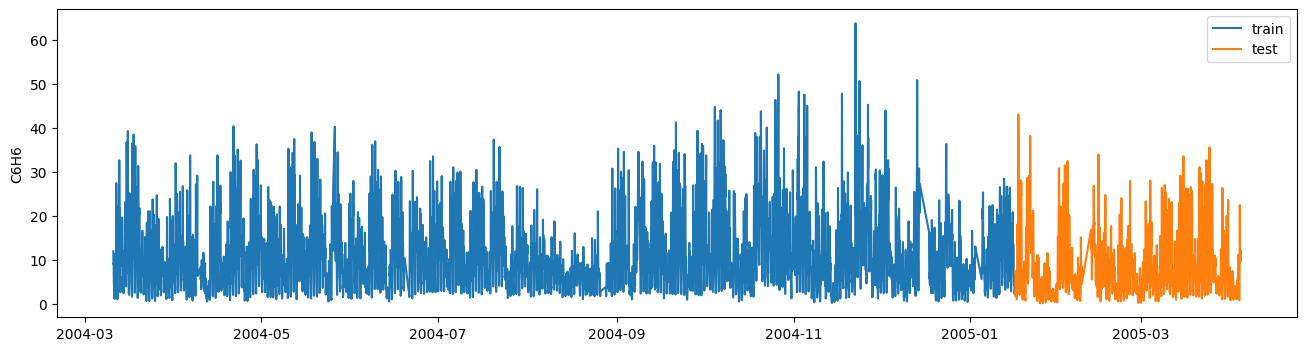

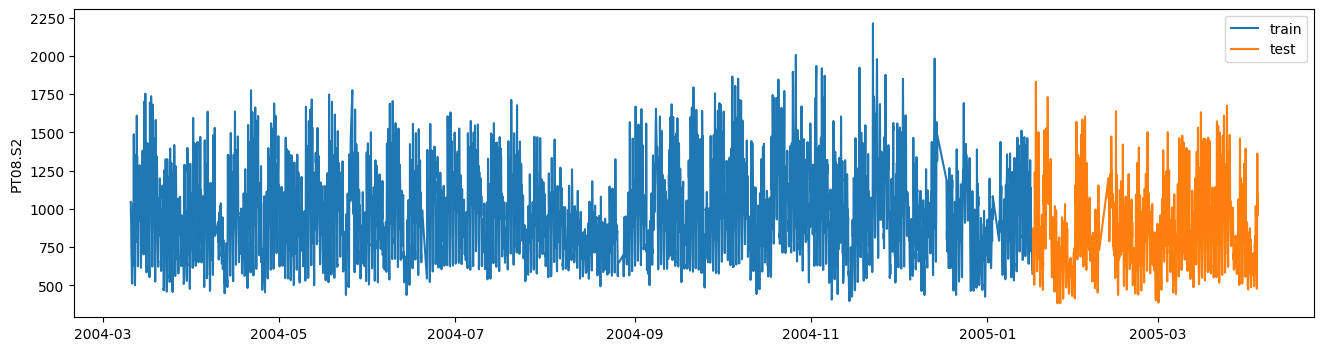

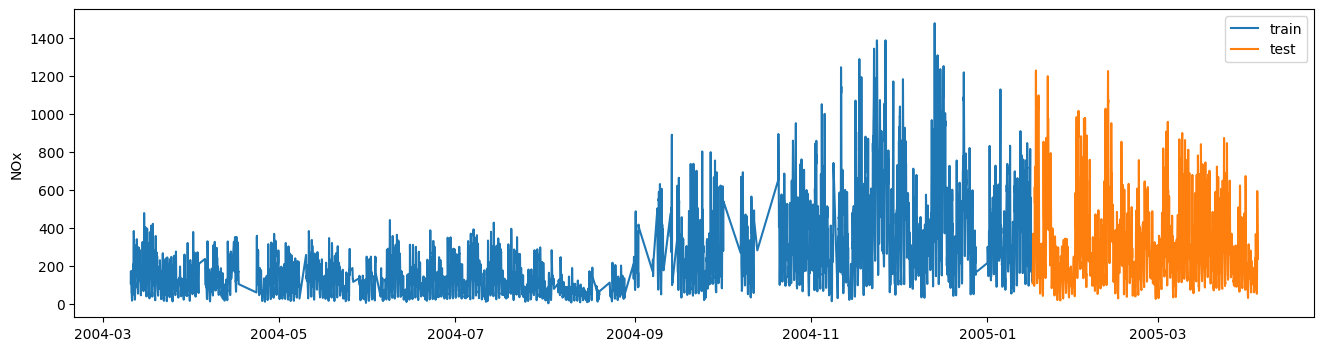

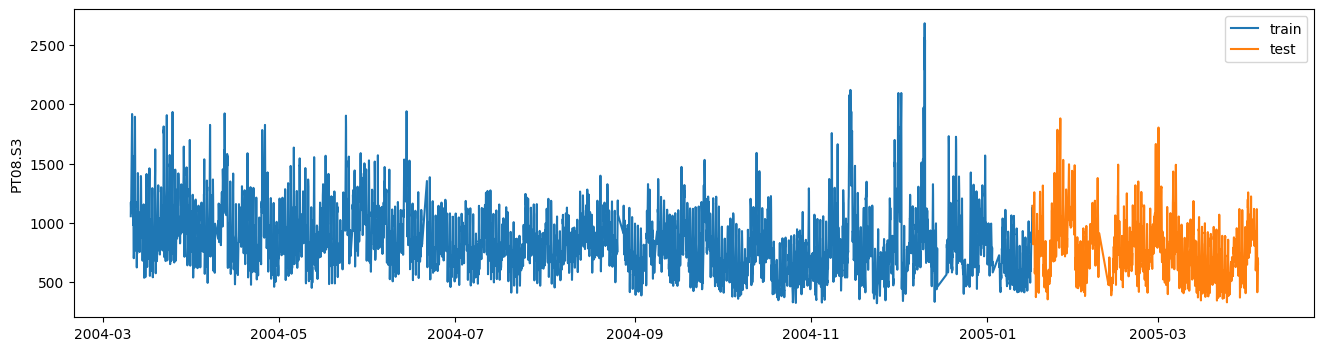

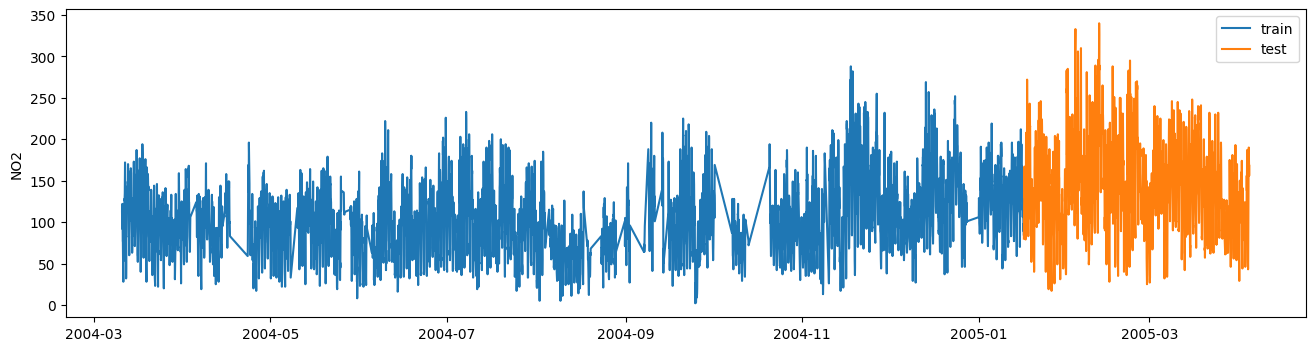

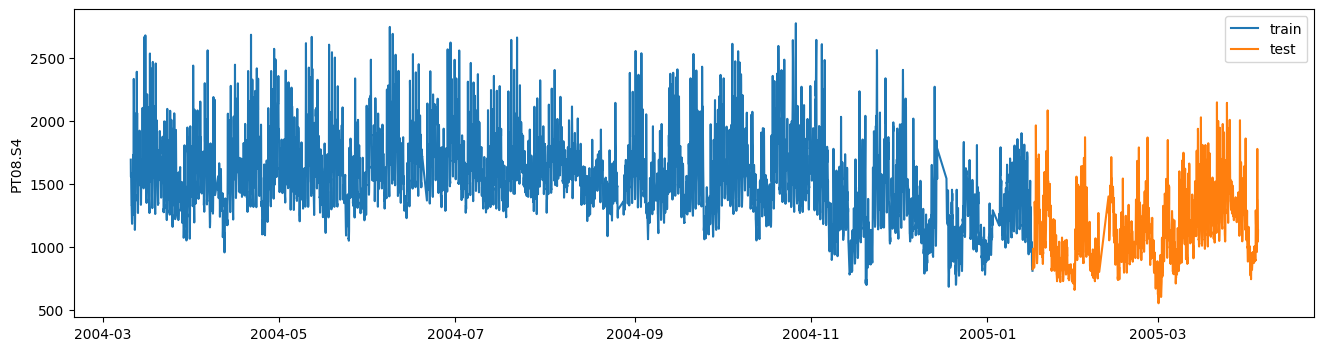

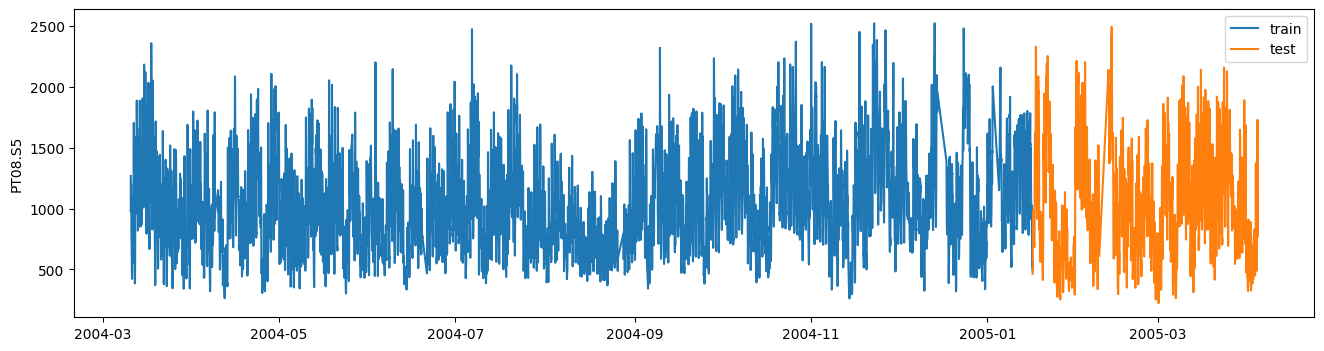

In [21]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

### VAR Modeling

With ARIMA we are using the past values of every variable to make the predictions for the future. When we have multiple time series at our disposal, we can also extract information from their relationships, in this way VAR is a multivariate generalization of ARIMA because it understands and uses the relationship between several inputs. This is useful for describing the dynamics behavior of the data and also provides better forecasting results. 

To correctly develop a VAR model, the same classical assumptions encountered when fitting an ARIMA, have to be satisfied. We need to grant stationarity and leverage autocorrelation behaviors. These prerequisities enable us to develop a stable model. All of our time series are stationary in mean and show a daily and weekly pattern

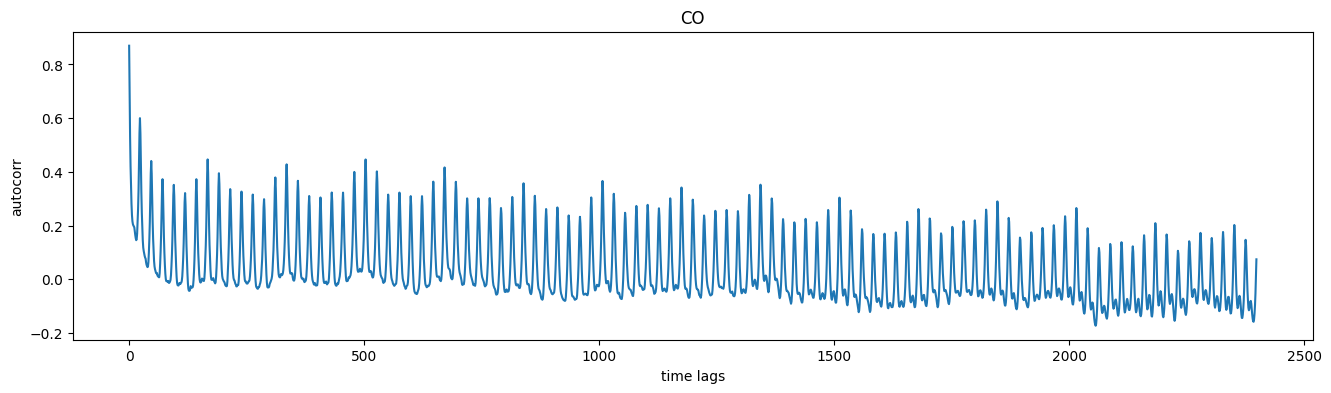

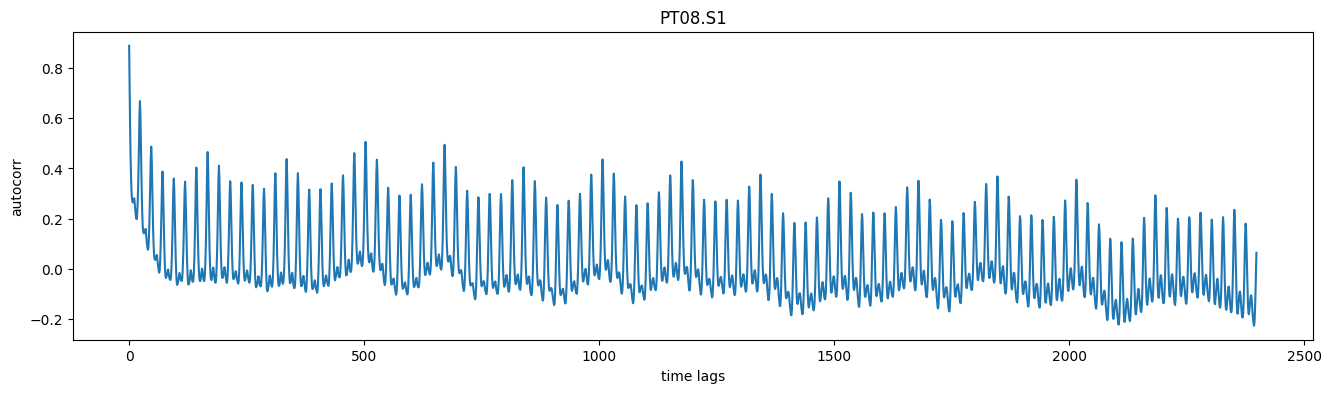

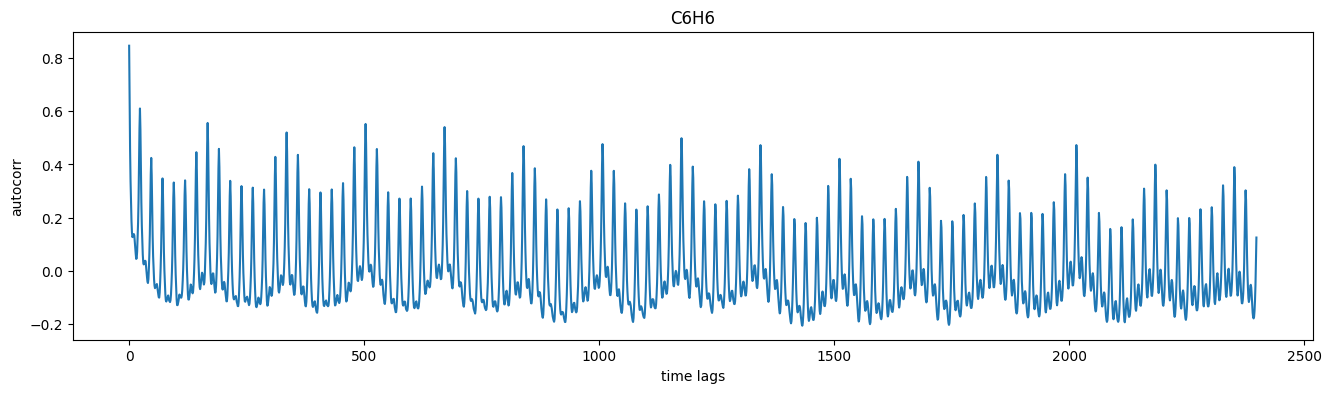

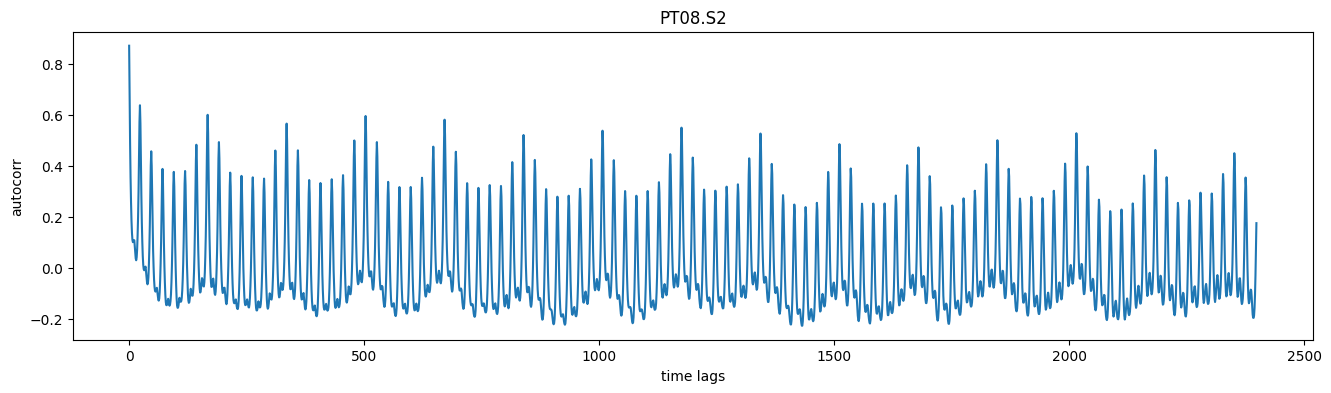

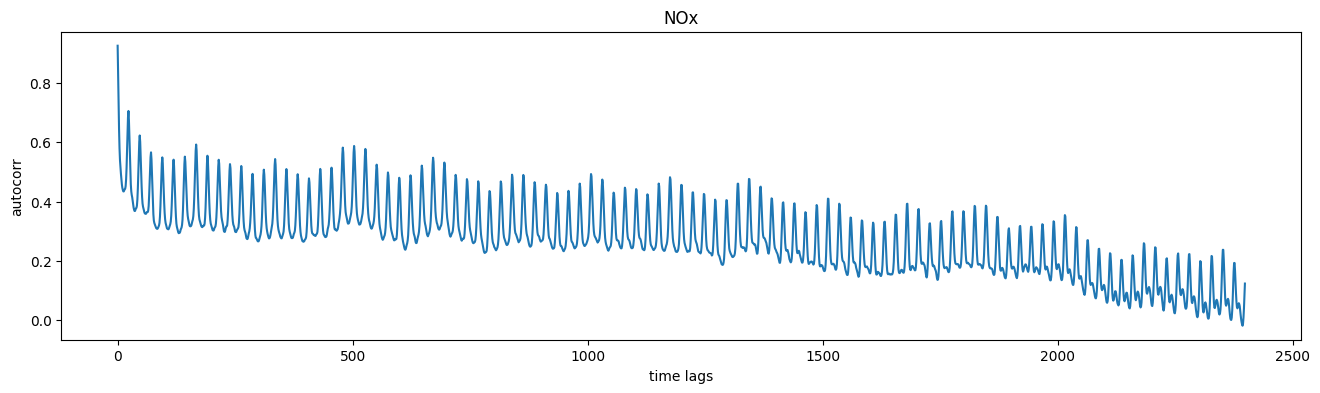

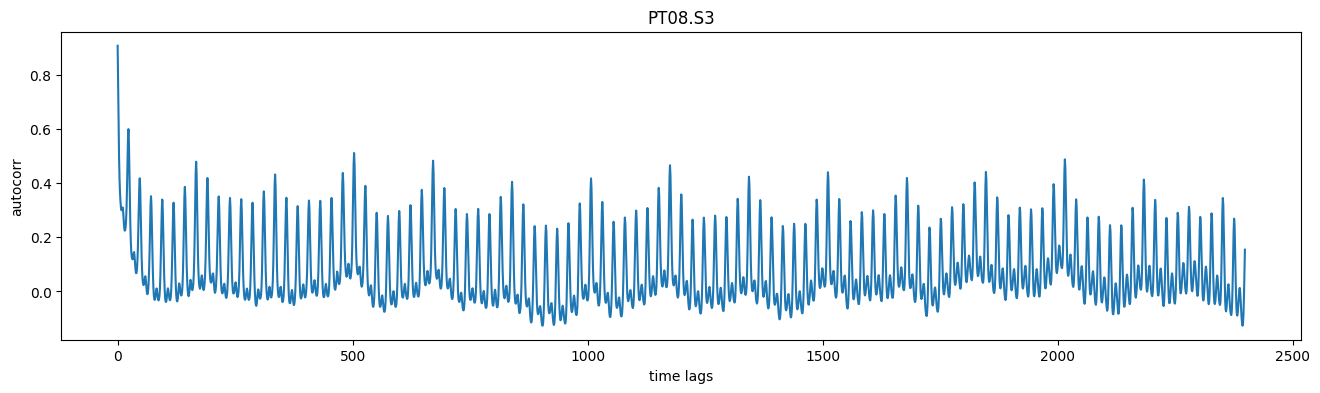

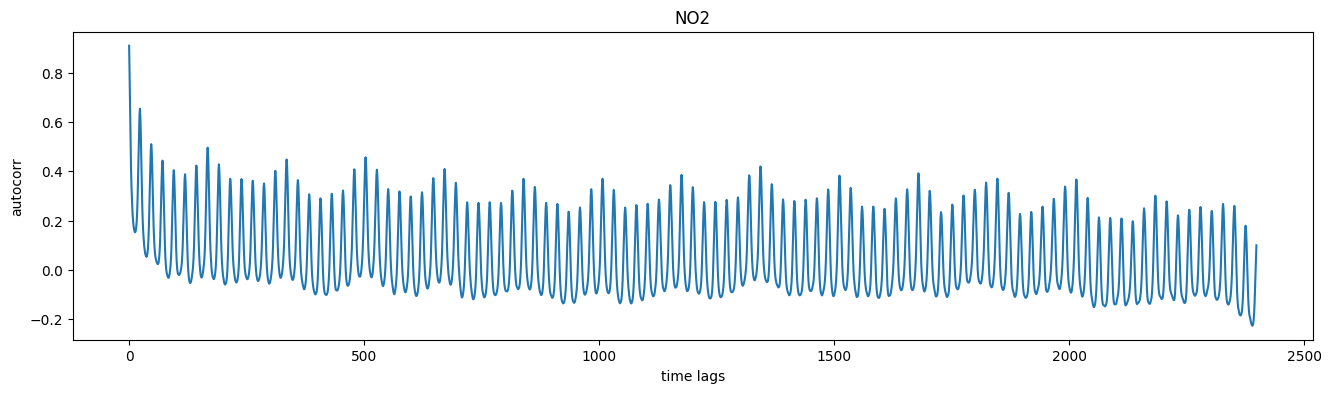

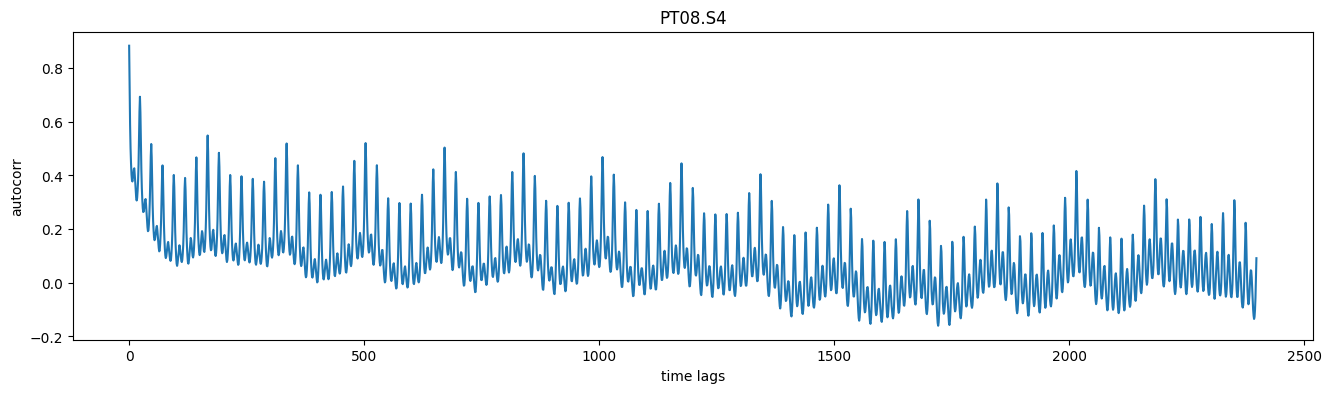

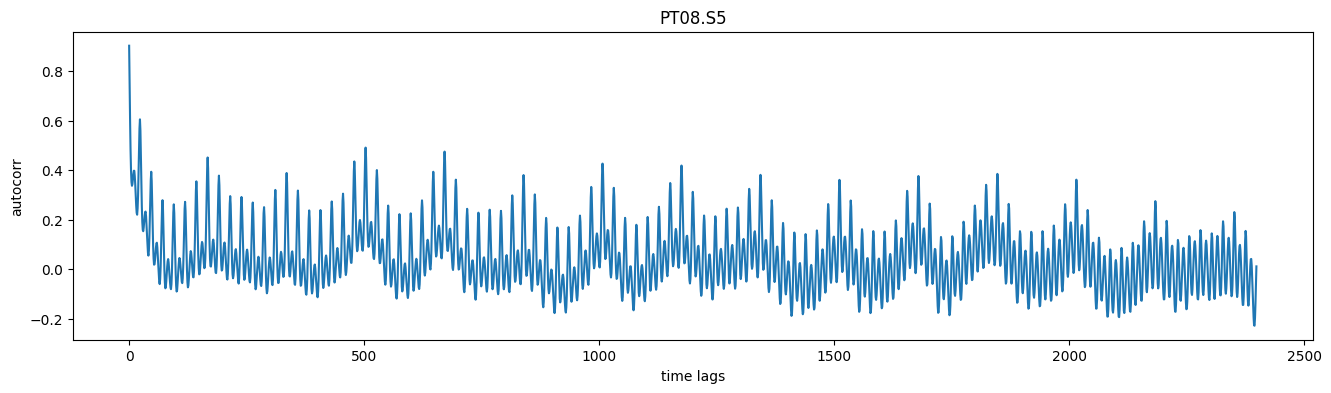

In [22]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

After these preliminary checks, we are ready to fit our VAR. The choice of the perfect lag order is made automatically with the AIC/BIC criterion. We operate the selection with the AIC: all we need to do is recursively fitting our model changing the lag order and annotate the AIC score (the lowest the better). This process can be carried out considering only our train data. In our case, 27 is the best lag order.

In [23]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in tqdm(range(1,100)):
    model = VAR(endog=train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

100%|██████████| 99/99 [04:31<00:00,  2.75s/it]

BEST ORDER: 27 BEST AIC: 48.27379308169797


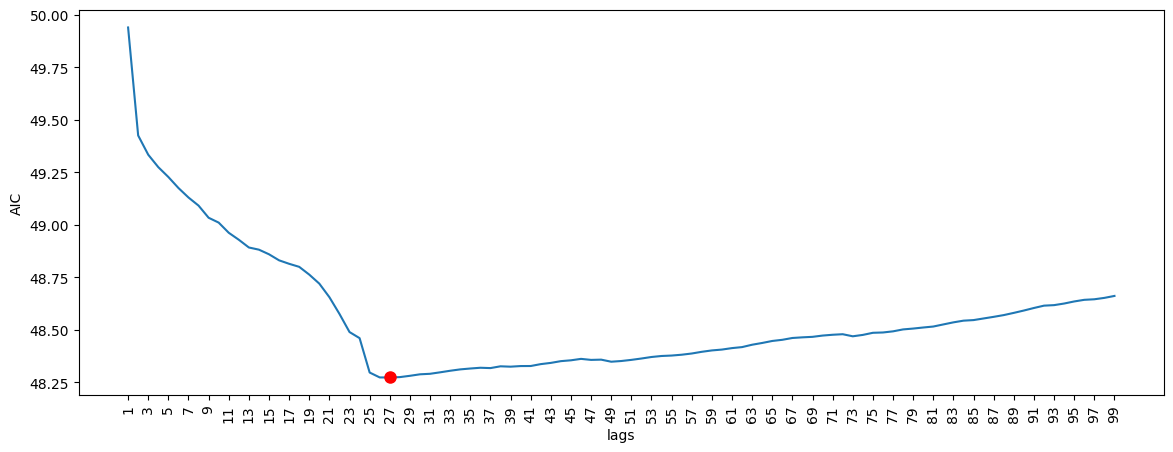

In [24]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 2), range(1,100, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [25]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

48.27379308169797

### Combine VAR and LSTM

Now our scope is to use our fitted VAR to improve the training of our neural network. The VAR has learned the internal behavior of our multivariate data source adjusting the insane values, correcting the anomalous trends, and reconstructing properly the NaNs. All these pieces of information are stored in the fitted values, they are a smoothed version of the original data which have been manipulated by the model during the training procedure. In other words, we can see these values as a kind of augmented data source of the original train.

Our strategy involves applying a two-step training procedure. We start feeding our LSTM autoencoder, using the fitted values produced by VAR, for multi-step ahead forecasts of all the series at our disposal (multivariate output). Then we conclude the training with the raw data, in our case they are the same data we used before to fit the VAR. With our neural network, we can also combine external data sources, for example, the weather conditions or some time attributes like weekdays, hours, and months that we cyclically encode.

We hope that our neural network can learn from two different but similar data sources and perform better on our test data. Our approach sounds great but this is not a ‘free lunch’. When performing multiple-step training we have to take care of the **Catastrophic Forgetting problem**. *Catastrophic forgetting is a problem faced by many models and algorithms. When trained on one task, then trained on a second task, many machine learning models “forget” how to perform the first task. This is widely believed to be a serious problem for neural networks.*

To avoid this tedious problem, the structure of the entire network has to be properly tuned to provide a benefit in performance terms. From these observations, we preserve a final part of our previous training as validation.

Technically speaking the network is very simple. It’s constituted by a seq2seq LSTM autoencoder which predicts the available sensors N steps ahead in the future. The training procedure is carried out using keras-hypetune. This framework provides hyperparameter optimization of the neural network structures in a very intuitive way. This is done for all three training involved (the fit on VAR fitted values, the fine-tuning fit with the raw data and the standard fit directly on the raw data).

In [26]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###


def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param, look_ahead, look_back):
    
    set_seed(33)
    
    opt = Adam()
    opt.lr = param['lr']
        
    inp = Input(shape=(look_back, 18))
    
    x = LSTM(param['units_lstm'], activation='tanh')(inp)
    x = RepeatVector(look_ahead)(x)
    x = LSTM(param['units_lstm'], activation='tanh', 
             return_sequences=True)(x)
    out = TimeDistributed(Dense(9))(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model


def get_model_finetune(param, kgs, look_ahead, look_back):
    
    set_seed(33)
    
    best_model_config = get_model(kgs.best_params, look_ahead, look_back)
    best_model_config.set_weights(kgs.best_model.get_weights())
    
    best_model_config.optimizer.lr = param['lr']
    
    return best_model_config

In [27]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': [128, 96, 64], 
    'lr': [7e-4, 1e-3, 3e-3], 
    'epochs': 200, 
    'batch_size': [512, 1024]
}

param_grid_finetune = {
    'lr': stats.loguniform(1e-5, 0.025), 
    'epochs': 200, 
}

In [28]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[best_order:].values
y_train_var = var_result.fittedvalues

X_train = np.concatenate([
    train.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([
    var_result.fittedvalues, train_ext.iloc[best_order:].values], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, shuffle=False, train_size=0.8)
X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(
    X_train_var, y_train_var, shuffle=False, train_size=0.8)

y_test = test.values
X_test = np.concatenate([test.values, test_ext.values], axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(5966, 18) (1492, 18) (1872, 18)
(5966, 18) (1492, 18)
(5966, 9) (1492, 9) (1872, 9)
(5966, 9) (1492, 9)


In [29]:
### SCALE DATA ###

scaler = StandardScaler()
scaler_y = StandardScaler()
scaler_var = StandardScaler()
scaler_y_var = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

y_train_var = scaler_y_var.fit_transform(y_train_var)
y_val_var = scaler_y_var.transform(y_val_var)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_var = scaler_var.fit_transform(X_train_var)
X_val_var = scaler_var.transform(X_val_var)

In [30]:
### BUILD DATA GENERATOR ###

look_back = 24*2
look_ahead = 6

X_train = create_windows(X_train, window_shape = look_back, end_id = -look_ahead)
y_train = create_windows(y_train, window_shape = look_ahead, start_id = look_back)
X_train_var = create_windows(X_train_var, window_shape = look_back, end_id = -look_ahead)
y_train_var = create_windows(y_train_var, window_shape = look_ahead, start_id = look_back)

X_val = create_windows(X_val, window_shape = look_back, end_id = -look_ahead)
y_val = create_windows(y_val, window_shape = look_ahead, start_id = look_back)
X_val_var = create_windows(X_val_var, window_shape = look_back, end_id = -look_ahead)
y_val_var = create_windows(y_val_var, window_shape = look_ahead, start_id = look_back)

X_test = create_windows(X_test, window_shape = look_back, end_id = -look_ahead)
y_test = create_windows(y_test, window_shape = look_ahead, start_id = look_back)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(5913, 48, 18) (1439, 48, 18) (1819, 48, 18)
(5913, 48, 18) (1439, 48, 18)
(5913, 6, 9) (1439, 6, 9) (1819, 6, 9)
(5913, 6, 9) (1439, 6, 9)


In [31]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs_var = KerasGridSearch(hypermodel, param_grid, 
                          monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_var.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')


2023-03-25 21:38:11.809002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.95037 at epoch 9

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.99456 at epoch 14

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.91755 at epoch 7

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.89598 at epoch 7

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.93816 at epoch 7

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.99379 at epoch 8

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.99652 at epoch 14

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.01411 at epoch 24

***** (9/18) *****
Sea

In [32]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, kgs=kgs_var, look_ahead=look_ahead, look_back=look_back)  

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                           monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.search(X_train, y_train, batch_size=kgs_var.best_params['batch_size'], 
              validation_data=(X_val, y_val), callbacks=[es])


20 trials detected for ('lr', 'epochs')

***** (1/20) *****
Search({'lr': 0.0003857635118975211, 'epochs': 200})
SCORE: 0.92249 at epoch 1

***** (2/20) *****
Search({'lr': 0.0005714173878534292, 'epochs': 200})
SCORE: 0.91592 at epoch 1

***** (3/20) *****
Search({'lr': 7.740755538615648e-05, 'epochs': 200})
SCORE: 0.91755 at epoch 1

***** (4/20) *****
Search({'lr': 0.0016506606834983432, 'epochs': 200})
SCORE: 0.88837 at epoch 1

***** (5/20) *****
Search({'lr': 0.0028975199561219536, 'epochs': 200})
SCORE: 0.95283 at epoch 4

***** (6/20) *****
Search({'lr': 7.456687844809637e-05, 'epochs': 200})
SCORE: 0.91633 at epoch 1

***** (7/20) *****
Search({'lr': 0.0009501006290131641, 'epochs': 200})
SCORE: 0.9093 at epoch 1

***** (8/20) *****
Search({'lr': 1.8215739071153037e-05, 'epochs': 200})
SCORE: 0.88998 at epoch 1

***** (9/20) *****
Search({'lr': 3.052974383613633e-05, 'epochs': 200})
SCORE: 0.89551 at epoch 1

***** (10/20) *****
Search({'lr': 9.772977050450925e-05, 'epochs': 

In [33]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

pred_lstm_var = krs_ft.best_model.predict(X_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var.reshape(-1, pred_lstm_var.shape[-1])).reshape(pred_lstm_var.shape)

57/57 [==============================] - 16s 63ms/step


In [34]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs = KerasGridSearch(hypermodel, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.95037 at epoch 9

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.99456 at epoch 14

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.91755 at epoch 7

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.89598 at epoch 7

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.93816 at epoch 7

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.99379 at epoch 8

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.99652 at epoch 14

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'b

In [35]:
### OBTAIN PREDICTIONS ###

pred_lstm = kgs.best_model.predict(X_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm.reshape(-1, pred_lstm.shape[-1])).reshape(pred_lstm.shape)

57/57 [==============================] - 6s 57ms/step


In [36]:
### COMPUTE METRICS ON TEST DATA ###

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(df.columns):
    
    error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = np.sqrt(error)

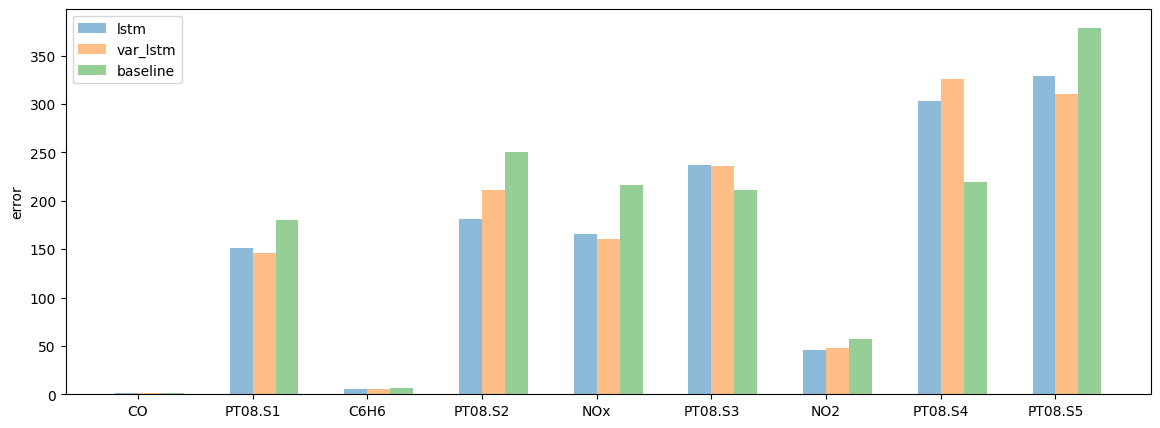

In [37]:
### COMPARE RESULTS ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(error_lstm))-0.1, error_lstm.values(), 
        alpha=0.5, width=0.2, label='lstm')
plt.bar(np.arange(len(error_var_lstm))+0.1, error_var_lstm.values(), 
        alpha=0.5, width=0.2, label='var_lstm')
plt.bar(np.arange(len(error_baseline))+0.3, error_baseline.values(), 
        alpha=0.5, width=0.2, label='baseline')
plt.xticks(range(len(error_lstm)), error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)

## Time Series Clustering and Dimensionality Reduction

Time Series must be handled with care by data scientists. This kind of data contains intrinsic information about temporal dependency. it’s our work to extract these golden resources, where it is possible and useful, in order to help our model to perform the best.

**Our purpose is to cluster them in an unsupervised way making use of deep learning, being wary of correlations, and pointing a useful technique that every data scientist must know!**



### The dataset

The data is the Public Dataset of Accelerometer Data for Human Motion Primitives Detection. *The data is a public collection of labelled acceloremeter data recordings to be used for the creation and validation of acceleration models of human motion primitives.*

Different types of activities are tracked like drinking, eating, climbing and so on. For a particular activity of a specific individual measured, we have 3 different sensro series at disposal.

I figure myself in this situation because it allows to carry out our initial problems of **clustering** (multiple individuals) and **dimensionality reduction** (multiple series for every individual) all in one single case.

Below I plot 2 examples of data at our disposal coming from a male and female individuals. In total, we have 20 individuals with the same measurement length.

In [38]:
import os
import random
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt

from scipy import stats
import scipy.cluster.hierarchy as sch

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [39]:
### READ DATA ###

data, person_id = [], []
for txt in listdir('Walk_MODEL'):
    measure = pd.read_csv('Walk_MODEL/'+txt, sep=' ', header=None).values
    data.append(measure)
    person_id.append(txt.split('-')[-1].split('.')[0])

data = np.asarray(data)
data.shape

FileNotFoundError: [Errno 2] No such file or directory: 'Walk_MODEL'

In [ ]:
### EXEMPLE OF DATA FOR A SINGLE INDIVIDUAL ###

plt.plot(data[11])
plt.legend(['X','Y','Z'])
plt.title(person_id[11]); plt.xlabel('Time')

In [ ]:
### STANDARDIZE DATA ###

for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)

### Dimensionality Reduction

We want to summarize all the information stored in sensor data all in one significative series. This latest step will enable us to easy cluster our individuals in groups.

There is a great variety of techniques which enable to reduce dimensionality in data, but our attention focused on Deep Learning algorithms. A neural network structure will permit us to handle easily our initial data: I remember you that we have 20 individuals and for every individual, we have 3 positional series of movements of length 170 (pythonic speaking we have an array of dimensions 20x170x3). The classical PCA based methods don’t permit us to carry out this kind of problem, so we built our handmade Autoencoder in Keras which takes care of our infamous original data structure.

In [ ]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def get_autoencoder(data):
    
    set_seed(33)

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(10, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(data.shape[2]))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

Above I’ve shown the architecture I’ve used: the TimeDistributed layer permits to deal with 3D data where the dimension of the index one will be considered to be the temporal dimension. For our experiment, we use the first 10 individuals to train our Autoencoder and utilize the rest to compute error reconstructions with the relative predictions. Don’t forget to standardize your data before to feed your Autoencoder! In our case, I’ve standardized the data for every person by single observation (by rows).

Our final reconstruction errors look like similar to this one below, where we have points near zeros when we are confident and we are able the detect the activity of this selected person; while we have high value when our model doesn’t learn enough and it has not so much confidence to reconstruct the walking activity.

In [ ]:
autoencoder = get_autoencoder(data)
autoencoder.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)

autoencoder = get_autoencoder(data)
autoencoder.fit(data[:10],data[:10], epochs=200, verbose=2, validation_data=(data[:10],data[:10]), callbacks=[es])

In [ ]:
### TRY TO RECONSTRUCT ERRORS ###

predictions = autoencoder.predict(data[[11]])
mse = np.mean(np.power(data[[11]] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.title('reconstruction error '+person_id[11])
plt.xlabel('time'); plt.ylabel('mse')

### Correlation Clustering

At this point, we have at disposal manageable objects (with dimension 175x1 for 20 individuals) and we are ready to proceed with clustering. Technically speaking, we operate hierarchical clustering on reconstruction errors of our test individuals. In order to catch important relationships among these series, we try two different instruments to assemble our clusters.

At the first stage, our choice involved the adoption of the Pearson Correlation index. **Unfortunately, this measure is very OVERSTIMATED and ABUSED in statistics and machine learning fields**, but we want to give it a chance…

After obtaining the correlation matrix, we operate directly on it performing the hierarchical clustering. We apply a high threshold (99% of the highest pairwise distance between sensor series) to form our flat clusters. This will result in the creation of high-level groups, small in number, but which give us a first impressive overview of our test data.

In [ ]:
# ### COMPUTE CORRELATION MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

In [ ]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(corr)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

In [ ]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

Looking at color intensities of the correlation matrix (on which we’ve just operated clustering procedures), we can’t see obvious group patterns. On the right, the cut (black line) of the dendrogram, after some initial ‘uncertainty’, doesn’t create rational groups. Male and female are mixed together without logic!

The Pearson Correlation index confirms again its unreliability, we have to go another way…

### Kolmogorov-Smirnov Clustering

Recently, I’ve read about Kolmogorov Smirnov statistic and this has produced a double effect to me: it has reminded me of the university and it has stolen my attention for its adaptability. This statistic, with the relative p-value, is used to measure the difference in distribution among two samples. I think that our clustering task is a good field of application for this killer instrument.

Compute this statistic is very easy with python and, in order to use it in our case, we only have to create the Kolmogorov Smirnov Matrix (equivalent to the Correlation Matrix) and reproduce the same steps we’ve done above.

In [ ]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

In [ ]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

In [ ]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

In [ ]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

Now, looking at the color intensity of our matrix (on which we’ve just operated clustering procedures), we can observe the presence of a pattern among females and males. As clearly visible in the dendrogram on the right, our hierarchical procedure has created two sensible groups, where men are all separated from women. The ‘uncertainty’, at the beginning of clusters building, is also disappeared.

This is the result we want, which confirms the importance of the presence of Kolmogorov Smirnov statistic in the arsenal of every data scientist.